**Цель задания**: сконструировать модель классификации фрукта на фотографии с помощью нейросети RES-Net и добиться метрики accuracy > 0.85

- Общее количество изображений: 22,495.
- Размер обучающего набора: 16 854 изображения.
- Размер тестового набора: 5 641 изображение.
- Количество классов: 33 (овощи и фрукты).
- Размер изображения: 100x100 пикселей.

Набор данных содержит различные фрукты и овощи, такие как апельсины, помидоры, маракуйя, огурцы и др.

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    print(dirname)

/kaggle/input/
/kaggle/input/fruit-recognition
/kaggle/input/fruit-recognition/test
/kaggle/input/fruit-recognition/test/test
/kaggle/input/fruit-recognition/train
/kaggle/input/fruit-recognition/train/train
/kaggle/input/fruit-recognition/train/train/Orange
/kaggle/input/fruit-recognition/train/train/Tomato
/kaggle/input/fruit-recognition/train/train/Passion Fruit
/kaggle/input/fruit-recognition/train/train/Cucumber Ripe
/kaggle/input/fruit-recognition/train/train/Cactus fruit
/kaggle/input/fruit-recognition/train/train/Pomegranate
/kaggle/input/fruit-recognition/train/train/Plum
/kaggle/input/fruit-recognition/train/train/Pineapple
/kaggle/input/fruit-recognition/train/train/Papaya
/kaggle/input/fruit-recognition/train/train/Potato Red
/kaggle/input/fruit-recognition/train/train/Kiwi
/kaggle/input/fruit-recognition/train/train/Limes
/kaggle/input/fruit-recognition/train/train/Apple Braeburn
/kaggle/input/fruit-recognition/train/train/Pear
/kaggle/input/fruit-recognition/train/train/O

**EDA и аугментация данных**

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [ ]:
transform1 = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor()
])

In [ ]:
transform2 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5)
])

In [ ]:
transform3 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

In [ ]:
train_data2= ImageFolder('/kaggle/input/fruit-recognition/train/train',transform = transform2)

In [ ]:
train_data1= ImageFolder('/kaggle/input/fruit-recognition/train/train',transform = transform1)

In [ ]:
train_data3 = ImageFolder('/kaggle/input/fruit-recognition/train/train',transform = transform3)

In [ ]:
import torch
from torch.utils.data import random_split

In [ ]:
classes = train_data1.classes

In [ ]:
len(classes)

33

In [ ]:
from collections import Counter

In [ ]:
counts = dict(Counter(train_data1.targets))

In [ ]:
counts.values()

dict_values([492, 492, 492, 427, 490, 462, 490, 492, 492, 490, 450, 392, 984, 466, 492, 490, 490, 438, 479, 492, 490, 492, 696, 444, 666, 490, 447, 492, 450, 490, 492, 738, 475])

In [ ]:
classes_values = dict(zip(classes, counts.values()))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
classes_list = list(counts.keys())

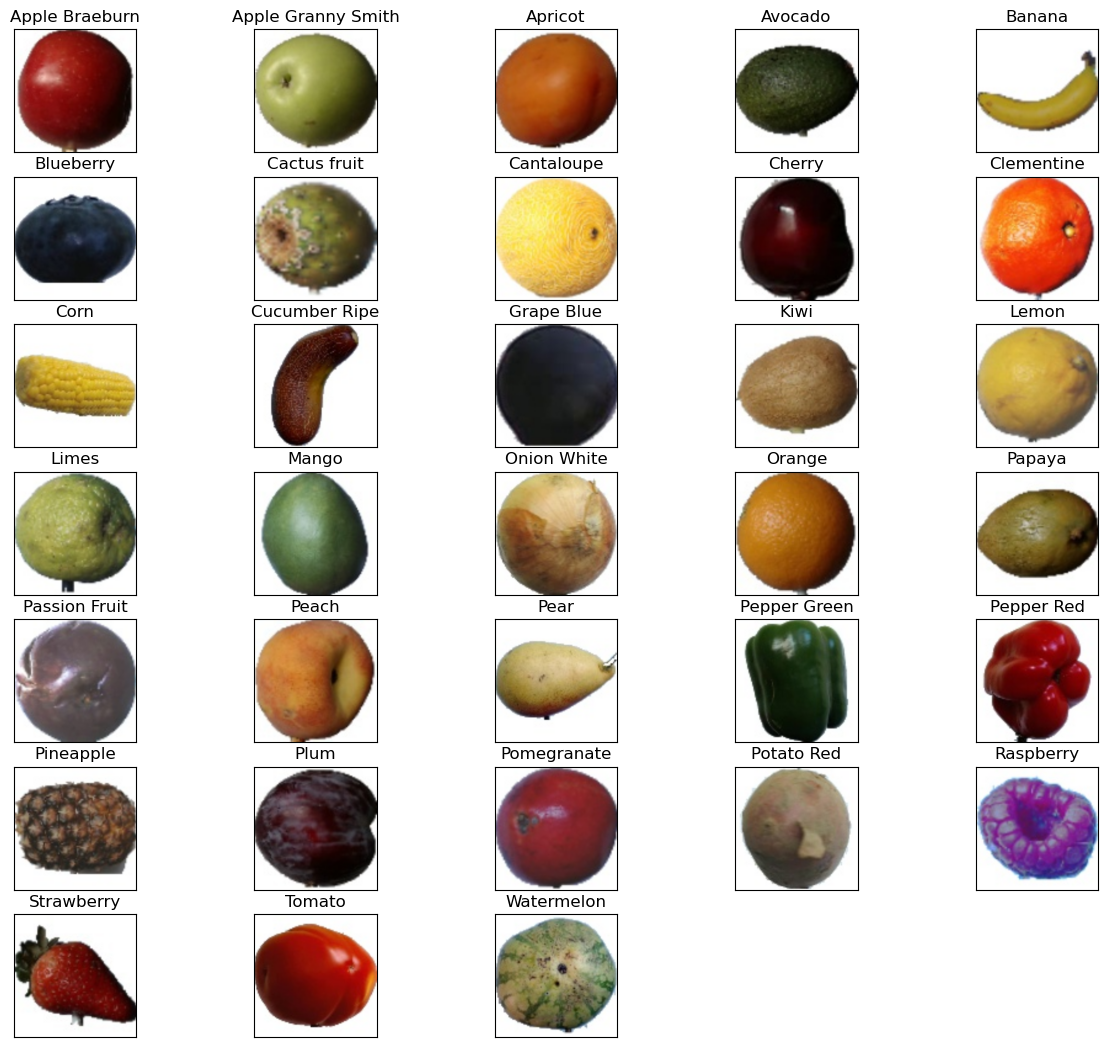

In [ ]:
fig = plt.figure(figsize=(15, 15))
rows = 8
columns = 5
count = 1
for img, label in train_data1:
    if label in classes_list:
        fig.add_subplot(rows, columns, count)
        plt.title(classes[label])
        plt.imshow(img.permute(1,2,0))
        classes_list.remove(label)
        plt.xticks([])
        plt.yticks([])
        count = count + 1
plt.show()

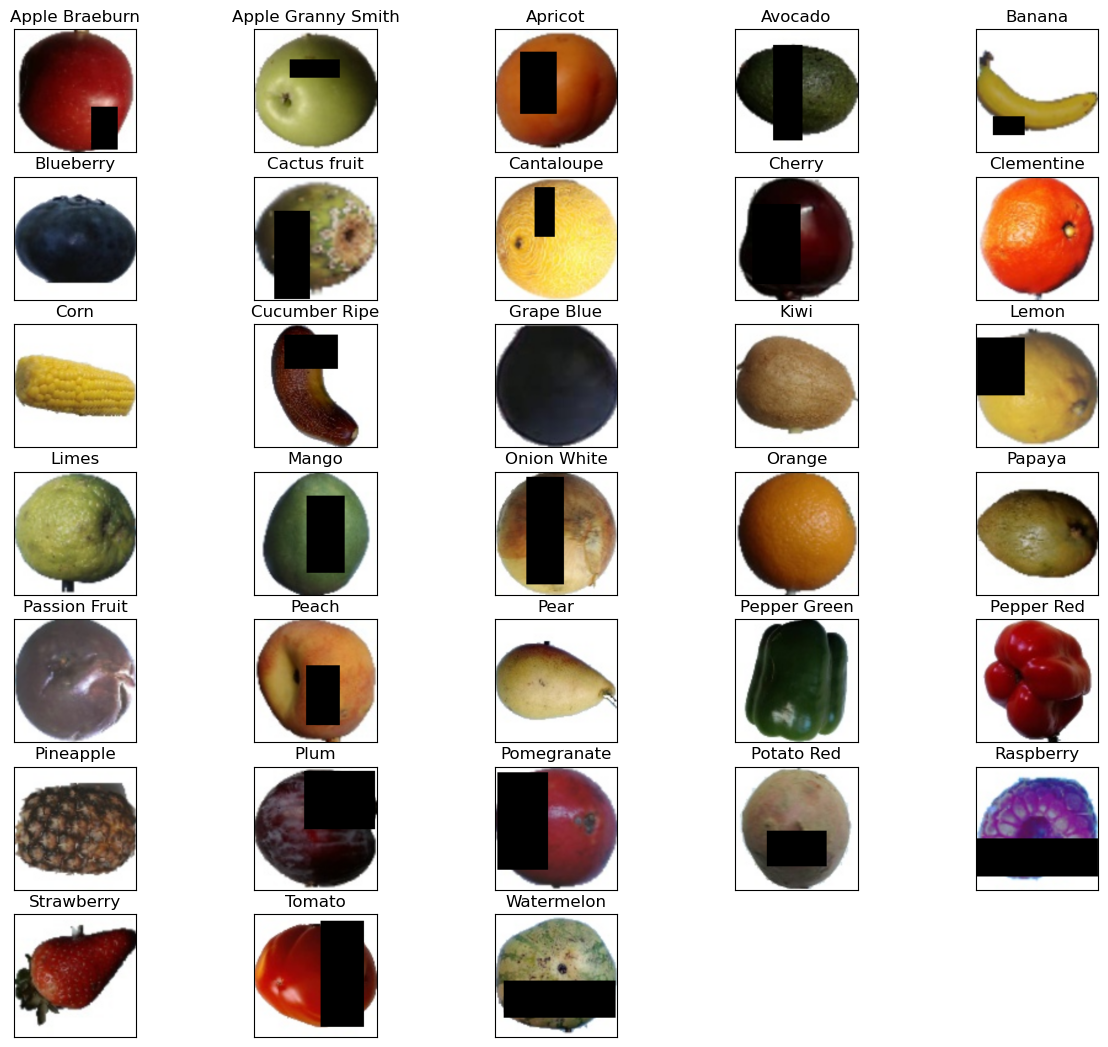

In [ ]:
classes_list = list(counts.keys())
fig = plt.figure(figsize=(15, 15))
rows = 8
columns = 5
count = 1
for img, label in train_data2:
    if label in classes_list:
        fig.add_subplot(rows, columns, count)
        plt.title(classes[label])
        plt.imshow(img.permute(1,2,0))
        classes_list.remove(label)
        plt.xticks([])
        plt.yticks([])
        count = count + 1
plt.show()

In [ ]:
train_ratio = 0.8
dataset_size = len(train_data1)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_data1, test_data = random_split(train_data1, [train_size, test_size])

In [ ]:
train_data = torch.utils.data.ConcatDataset([train_data2, train_data1])

**Обучение модели**

In [ ]:
import torch
import tqdm

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

**Создание архитектуры RES-Net**

In [ ]:
import torch
import torch.nn as nn

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

# ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [ ]:
model = ResNet18(33)

In [ ]:
import torch.nn.parallel as parallel

In [ ]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = parallel.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Using 2 GPUs!


DataParallel(
  (module): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Identity()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

**Оптимизация**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.001)

In [ ]:
from tqdm import tqdm

In [ ]:
train_accuracies = []
test_accuracies = []
num_epochs = 5
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train

    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test

    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

100%|██████████| 475/475 [01:50<00:00,  4.31it/s]


Epoch 1/5 - Train Loss: 1.6210 - Train Acc: 0.6582 - Test Loss: 0.6703 - Test Acc: 0.8799


100%|██████████| 475/475 [01:44<00:00,  4.53it/s]


Epoch 2/5 - Train Loss: 0.5359 - Train Acc: 0.9087 - Test Loss: 0.2964 - Test Acc: 0.9448


100%|██████████| 475/475 [01:45<00:00,  4.50it/s]


Epoch 3/5 - Train Loss: 0.3101 - Train Acc: 0.9464 - Test Loss: 0.1580 - Test Acc: 0.9763


100%|██████████| 475/475 [01:46<00:00,  4.48it/s]


Epoch 4/5 - Train Loss: 0.2132 - Train Acc: 0.9647 - Test Loss: 0.1608 - Test Acc: 0.9689


100%|██████████| 475/475 [01:45<00:00,  4.51it/s]


Epoch 5/5 - Train Loss: 0.1557 - Train Acc: 0.9754 - Test Loss: 0.0887 - Test Acc: 0.9852


**Выводы и оценка качества модели**

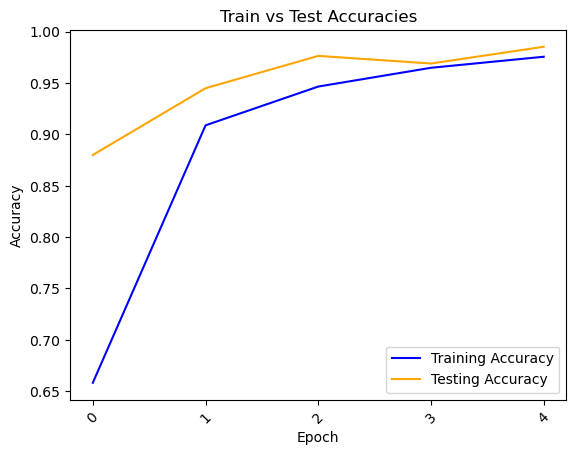

In [ ]:
sns.lineplot(x = range(5), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(5), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,5), rotation = 45)
plt.yticks(label = range(0,1))
plt.legend()
plt.show()

Нейросеть, состоящая из 5 эпох, предсказывает верно 98% фотографий фруктов